In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import pylab
import astropy
import csv
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle
import matplotlib.patches as mpatches
from astropy.io import fits
from matplotlib.colors import LogNorm
import random
from astropy.io import ascii
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch
import math


In [3]:
def getimages(ra,dec,size=240,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im


In [4]:
data=ascii.read('comp_004_wqn1993.csv', data_start=3123, data_end=13123)

In [27]:
i=1

# cell for check individual image. it will skip bad Galfit resuts, and to go to nxt source simply run the cell again

4 207.595001220703
-19.129980658217544 0.018172542929720367 38.49736022949216 37.123143381258714
0.422376990318298 0.410120010375977 -0.00966607965528965


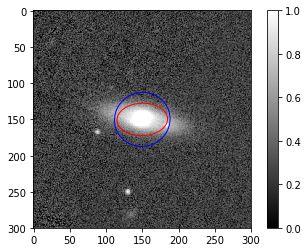

In [7]:
while data['gGalChisq'][i]<0:
    i=i+1
    
print(i, data['gGalChisq'][i])# modify this if you want to check more info in data table
ra = data['ra'][i]
dec = data['dec'][i]
size = 300  #PS cutout image size
 
#downloading image part
fitsurl = geturl(ra, dec, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])
fim = fh[0].data
fim[np.isnan(fim)] = 0.
transform = AsinhStretch() + PercentileInterval(99)
bfim = transform(fim)
fig, ax = plt.subplots(1, 1)
plt.imshow(bfim, cmap='gray')#, norm=LogNorm())
plt.colorbar()

#initialize image
x0, y0 = size/2, size/2  
y, x = np.mgrid[0:2*x0, 0:2*y0]# 4 pixel for 1 arcsec for PS1, here image size is set to be 20"*20", depend on your cutout image size

#make fitted image

#fit from 2nd moment
theta1 = math.degrees(np.arctan(data['gmomentXY'][i]/(data['gmomentXX'][i]-data['gmomentYY'][i])))/2#rot angle
t=data['gmomentXY'][i]/np.sin(2*theta1)
a1= 4*n_radius*data['gmomentR1'][i] # 4pix/arcsec * n_radius*a, 4pix/arcsec * n_radius*a*b/a 
b1= a1*(1-t)/(1+t)
e1 = mpatches.Ellipse((x0, y0), 2*a1, 2*b1, theta1, edgecolor='blue',
                          facecolor='none')    
print(theta1,t,a1,b1)
print(data['gmomentXX'][i],data['gmomentYY'][i],data['gmomentXY'][i])

ax.add_patch(e1)


#fit from Galfit
n_radius=2 #no. of radius we want to see
a2, b2 = 4*n_radius*data['gGalMajor'][i],  4*n_radius*data['gGalMinor'][i]# 4pix/arcsec * n_radius*a, 4pix/arcsec * n_radius*a*b/a 
theta2 = Angle(data['gGalPhi'][i], 'deg')#rot angle
e2 = mpatches.Ellipse((x0, y0), 2*a2, 2*b2, theta2.degree, edgecolor='red',
                          facecolor='none')    
ax.add_patch(e2)
plt.show()
i=i+1


# Below are some test codes or codes for checking data

In [33]:
for i in range(10000):
    if data['gmomentXX'][i]>1:
        print (data['gmomentXX'][i],data['gmomentYY'][i], data['gmomentXY'][i])

In [31]:
for i in range(10):
    theta = np.arctan(data['gmomentXY'][i]/(data['gmomentXX'][i]-data['gmomentYY'][i]))/2#rot angle
    print (theta, (data['gmomentXX'][i]-data['gmomentYY'][i])/np.cos(2*theta), data['gmomentXY'][i]/np.sin(2*theta))


0.16513897675737096 -0.00793380398653977 -0.00793380398653977
0.16513897675737096 -0.00793380398653977 -0.00793380398653977
-0.20535090610383666 0.009714870697860827 0.009714870697860827
-0.20535090610383666 0.009714870697860827 0.009714870697860827
-0.3338811483287282 0.015609825534222469 0.015609825534222469
-0.3338811483287282 0.015609825534222469 0.015609825534222469
-0.18077193487682774 -0.028503721670345216 -0.028503721670345213
-0.18077193487682774 -0.028503721670345216 -0.028503721670345213
-0.4361211224828464 0.044748125008077996 0.044748125008077996
-0.4361211224828464 0.044748125008077996 0.044748125008077996


In [8]:
k=0
for n in range(48356):
    if data['gGalChisq'][n]<0:
        k=k+1
print(k)

12007
